In [336]:
import pandas as pd 
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torch.utils.data as data_utils
import itertools
from sklearn.metrics import confusion_matrix

path = "/datasets/home/73/673/h6gupta/Challenge/challenge_dataset.csv"
data = pd.read_csv(path, header = None)
data = data.convert_objects(convert_numeric=True)

df1 = data.iloc[1:,2:16].values.reshape(205,89,14)
df1 = np.moveaxis(df1, [1,2], [2,1])

labels =[]
for i in range(1,206):
    labels.append(data.iloc[89*i,16])

labels = np.asarray(labels).astype('int64')

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [337]:
X_train = (df1 - np.mean(df1, axis=0)[None,:,:]) / np.std(df1, axis=0)[None,:,:]

In [338]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels, stratify = labels, test_size = 0.15)
y_tr = lab_tr
y_vld = lab_vld

img = torch.from_numpy(X_tr).float().cuda()
lbl = torch.from_numpy(y_tr).long().cuda()


batch_size = 40

train = data_utils.TensorDataset(img,lbl)
data_loader = data_utils.DataLoader(train, batch_size = batch_size, shuffle = True)
print(img.size())
print(lbl.size())
print(type(img))
print(type(lbl))


torch.Size([174, 14, 89])
torch.Size([174])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [342]:
class LSTM(nn.Module):
    def __init__(self, num_classes):
        super(LSTM, self).__init__()
        self.input_dim = 14
        self.hidden_dim = 64
        self.num_layers = 1

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, num_classes)
        
    def init_hidden(self, batch_size):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, batch_size, self.hidden_dim).cuda(),
                torch.randn(self.num_layers, batch_size, self.hidden_dim).cuda())
        
    def forward(self, X):
        batch_size = X.shape[1]
        output, self.hidden = self.lstm(X, self.hidden)
        y = self.linear(output[-1].view(batch_size, -1))
        #y = self.softmax(y)
        return y        

In [343]:
num_epochs = 1001
model = LSTM(3).cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def lr_decay(optimizer, epoch, init_lr=0.001, lr_decay_epoch=400):
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

Testing Accuracy: 0.23


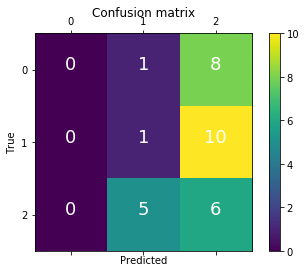

In [344]:
def accuracy(yinit_v1, lbl_v1):
    return (torch.max(yinit_v1.data, 1)[1].long() == lbl_v1.data).sum().item()

img_v1 = torch.from_numpy(X_vld).float().cuda()
lbl_v1 = torch.from_numpy(y_vld).long().cuda()
model.hidden = model.init_hidden(img_v1.shape[0])
yinit_v1 = model(img_v1.transpose(1,0).transpose(0,2))
print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))


preds= torch.max(yinit_v1.data, 1)[1].cpu().numpy()
true = lbl_v1.data.cpu().numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()



In [345]:
mc = 0
train_acc = []
test_acc =  []
acc = 0.0
for epoch in range(num_epochs):
    model.train()
    mc = 0
    for inp, out in data_loader:
        model.zero_grad()
        batch_size = inp.shape[0]
        model.hidden = model.init_hidden(batch_size)
        
        inp = inp.transpose(1,0).transpose(0,2)
        pred = model(inp)
    
        loss = loss_function(pred, out)
        loss.backward()
        
        optimizer.step()
        mc += ((torch.max(pred.data, 1)[1].long() == out.data).sum().item())
        
    if epoch % 50 == 0:
        model.eval()
        model.hidden = model.init_hidden(img_v1.shape[0])
        yinit_v1 = model(img_v1.transpose(1,0).transpose(0,2))
        test_acc.append(((accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0]))))
        train_acc.append(mc/float(img.shape[0]))
        print(epoch, loss.item(), mc/float(img.shape[0]), (accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0])))
        
        if((accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0])) > acc ):
            torch.save(model.state_dict(), 'LSTMModel.pth')
            acc = (accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0]))
            print('Model File Saved !')

(0, 1.111738681793213, 0.27011494252873564, 0.25806451612903225)
Model File Saved !
(50, 1.1617721319198608, 0.5689655172413793, 0.4838709677419355)
Model File Saved !
(100, 0.808106541633606, 0.632183908045977, 0.5161290322580645)
Model File Saved !
(150, 0.6556061506271362, 0.735632183908046, 0.6129032258064516)
Model File Saved !
(200, 0.45239004492759705, 0.7758620689655172, 0.6129032258064516)
(250, 0.5738756060600281, 0.7758620689655172, 0.6129032258064516)
(300, 0.5290581583976746, 0.7988505747126436, 0.5483870967741935)
(350, 0.5624353885650635, 0.7931034482758621, 0.5483870967741935)
(400, 0.3682890832424164, 0.8103448275862069, 0.4838709677419355)
(450, 0.15060070157051086, 0.8160919540229885, 0.5161290322580645)
(500, 0.38143157958984375, 0.8390804597701149, 0.5161290322580645)
(550, 0.39412063360214233, 0.8448275862068966, 0.5161290322580645)
(600, 0.22130770981311798, 0.8505747126436781, 0.5161290322580645)
(650, 0.4254242479801178, 0.8563218390804598, 0.4838709677419355)


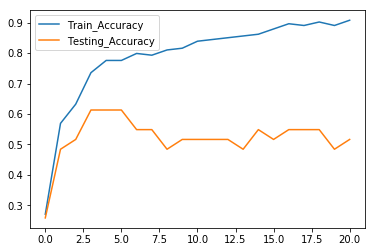

In [346]:
t = np.arange(num_epochs//50 + 1)
plt.plot(t, train_acc)
plt.plot(t, test_acc)
plt.legend(['Train_Accuracy', 'Testing_Accuracy'])
plt.show()

In [347]:
model = LSTM(3).cuda()
model.load_state_dict(torch.load('LSTMModel.pth'))

batch_size = img_v1.shape[0]
model.hidden = model.init_hidden(batch_size)
yinit_v1 = model(img_v1.transpose(1,0).transpose(0,2))
print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))

Testing Accuracy: 0.61


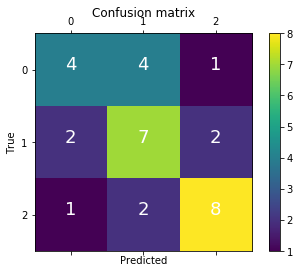

In [348]:
preds= torch.max(yinit_v1.data, 1)[1].cpu().numpy()
true = lbl_v1.data.cpu().numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()